In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time

In [2]:
from mpl_toolkits import mplot3d

In [3]:
%matplotlib notebook

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [6]:
def cuda_wrapper(torch_obj):
    return torch_obj.cuda() if USE_CUDA else torch_obj

In [7]:
def uniform_samples_from_unit_sphere(n_features, n_samples):
    X = np.random.normal(size=(n_samples, n_features))
    return X / np.sqrt(np.sum(X ** 2, axis=1, keepdims=True))

In [30]:
n_features = 100
n_latent = 10
n_samples = 1024

X_prelim = uniform_samples_from_unit_sphere(n_latent+1, n_samples)
X_prelim.shape

(1024, 11)

In [31]:
X = np.hstack((X_prelim, np.zeros((X_prelim.shape[0], n_features - n_latent - 1))))
X.shape

(1024, 100)

In [32]:
def sample_unitary_matrix(n):
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / np.sqrt(2.0)
    q, r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d / np.absolute(d)
    return ph * q

In [33]:
Q, _ = np.linalg.qr(np.random.normal(size=(n_features, n_features)))
Q.shape

(100, 100)

In [34]:
X = X @ Q

In [41]:
X_test_prelim = uniform_samples_from_unit_sphere(n_latent+1, n_samples)
X_test = np.hstack((X_test_prelim, np.zeros((X_test_prelim.shape[0], n_features - n_latent - 1))))
X_test = X_test @ Q

In [36]:
def batch_generator(data, batch_size):
    data_size = data.shape[0]
    indices = np.random.permutation(data_size)
    for i in range(0, data_size, batch_size):
        if i+batch_size > data_size:
            yield torch.from_numpy(data[indices[i:]]).float()
        else:
            yield torch.from_numpy(data[indices[i:i+batch_size]]).float()

**AE**

In [37]:
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2):
        super(type(self), self).__init__()

        self.encoder = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.encoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.encoder.append(nn.Softplus())
        self.encoder.append(nn.Linear(hidden_dim, latent_dim))

        self.decoder = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.decoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.decoder.append(nn.Softplus())
        self.decoder.append(nn.Linear(hidden_dim, input_dim))

    def forward(self, X):
        Z = self.encode(X)
        return self.decode(Z)
    
    def encode(self, X):
        Z = X
        for layer in self.encoder:
            Z = layer(Z)
        return Z
    
    def decode(self, Z):
        X = Z
        for layer in self.decoder:
            X = layer(X)
        return X

In [44]:
epoch_count = 25000

model = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=n_latent-1))
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        X_batch_fit = model(X_batch_requires_grad)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count

    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        X_batch_fit = model(X_batch_requires_grad)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, mean_scalar_product, mean_test_scalar_product
            )
        )


epoch 500; loss = 0.0015 : 0.0018, scalar product = 3.6275 : 3.4797
epoch 1000; loss = 0.0014 : 0.0018, scalar product = 3.9573 : 3.7507
epoch 1500; loss = 0.0010 : 0.0015, scalar product = 4.3548 : 4.2793
epoch 2000; loss = 0.0006 : 0.0011, scalar product = 5.6757 : 5.8093
epoch 2500; loss = 0.0004 : 0.0010, scalar product = 5.2954 : 5.1007
epoch 3000; loss = 0.0003 : 0.0009, scalar product = 3.1115 : 3.9405
epoch 3500; loss = 0.0003 : 0.0008, scalar product = 1.6048 : 2.9389
epoch 4000; loss = 0.0002 : 0.0009, scalar product = 1.2350 : 3.5486
epoch 4500; loss = 0.0002 : 0.0010, scalar product = 1.3433 : 8.1936
epoch 5000; loss = 0.0001 : 0.0011, scalar product = 1.6140 : 13.2999
epoch 5500; loss = 0.0001 : 0.0012, scalar product = 1.8846 : 24.9584
epoch 6000; loss = 0.0001 : 0.0013, scalar product = 2.0477 : 82.2447
epoch 6500; loss = 0.0001 : 0.0014, scalar product = 2.3723 : 60.1158
epoch 7000; loss = 0.0001 : 0.0015, scalar product = 2.6850 : 84.0915
epoch 7500; loss = 0.0001 : 0.

In [ ]:
# latent_dim = n_latent: (0.04 : 0.05)
# latent_dim = n_latent+1: (3.91 : 3.91)
# latent_dim = n_latent-1: (6.20 : 2563.85)


In [45]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


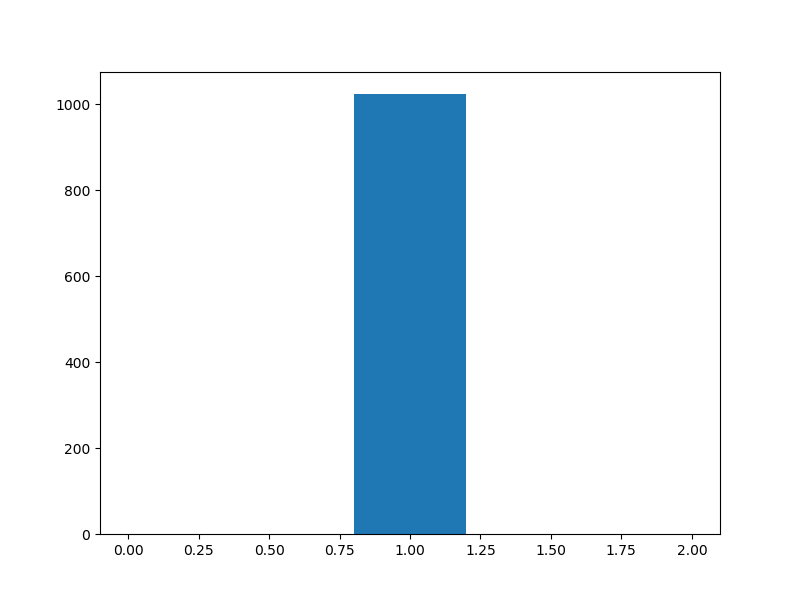

(array([    0.,     0.,  1024.,     0.,     0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [50]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [48]:
Z_test_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X_test).float())))
X_test_fit = model.decode(Z_test_fit).data.cpu().numpy()
Z_test_fit = Z_test_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


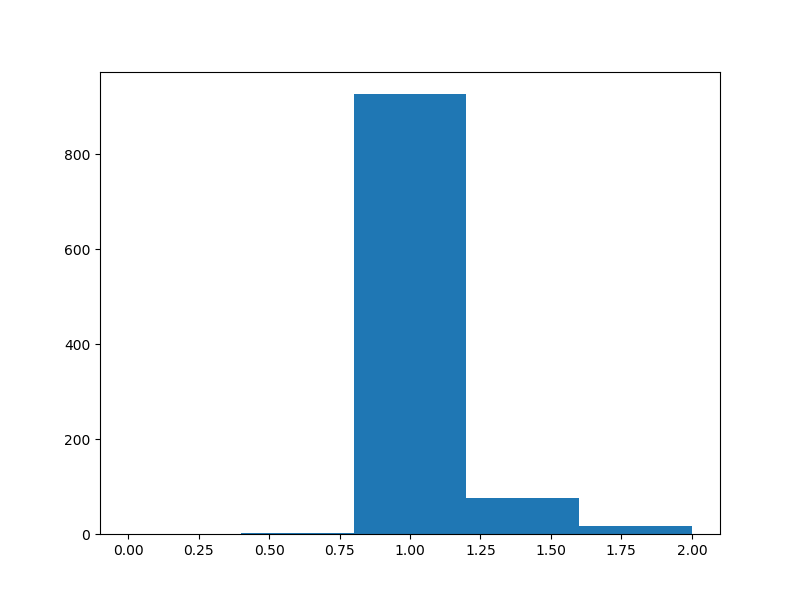

(array([   0.,    2.,  927.,   75.,   16.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [52]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_test_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

**CAE**

In [81]:
epoch_count = 500000

model = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=n_latent+10))
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

contraction_factor = 1e-6

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = model.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    
    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = model.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_contraction_loss = cum_contraction_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, contraction loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, 
                mean_contraction_loss, mean_test_contraction_loss, 
                mean_scalar_product, mean_test_scalar_product
            )
        )


epoch 500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 4.1040 : 4.0996
epoch 1000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 4.0624 : 4.0661
epoch 1500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 4.0468 : 4.0427
epoch 2000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 4.0419 : 4.0079
epoch 2500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 4.0310 : 4.0165
epoch 3000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 4.0099 : 3.9907
epoch 3500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 4.0121 : 3.9915
epoch 4000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.9921 : 4.0188
epoch 4500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.9886 : 3.9832
epoch 5000; loss = 0.0000 : 0.0000, contraction loss = 0

epoch 39500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.3113 : 3.3126
epoch 40000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.3041 : 3.3107
epoch 40500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.2910 : 3.2934
epoch 41000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.2840 : 3.2848
epoch 41500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.2738 : 3.2733
epoch 42000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.2572 : 3.2622
epoch 42500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.2482 : 3.2558
epoch 43000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.2429 : 3.2377
epoch 43500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 3.2314 : 3.2305
epoch 44000; loss = 0.0000 : 0.0000, contracti

epoch 78500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5940 : 2.5861
epoch 79000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5925 : 2.5903
epoch 79500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5829 : 2.5853
epoch 80000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5735 : 2.5743
epoch 80500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5663 : 2.5728
epoch 81000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5586 : 2.5594
epoch 81500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5546 : 2.5590
epoch 82000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5462 : 2.5477
epoch 82500; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 2.5377 : 2.5380
epoch 83000; loss = 0.0000 : 0.0000, contracti

KeyboardInterrupt: 

In [ ]:
# contraction_factor = 1e-6
# latent_dim = n_latent: (1.23 : 1.49), (0.17 : 0.31)
# latent_dim = n_latent+1: (3.66 : 3.67), (3.21 : 3.21)
# latent_dim = n_latent+10: (3.66 : 3.66), (3.13 : 3.13), (2.64 : 2.65), (2.5 : 2.5)


In [62]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


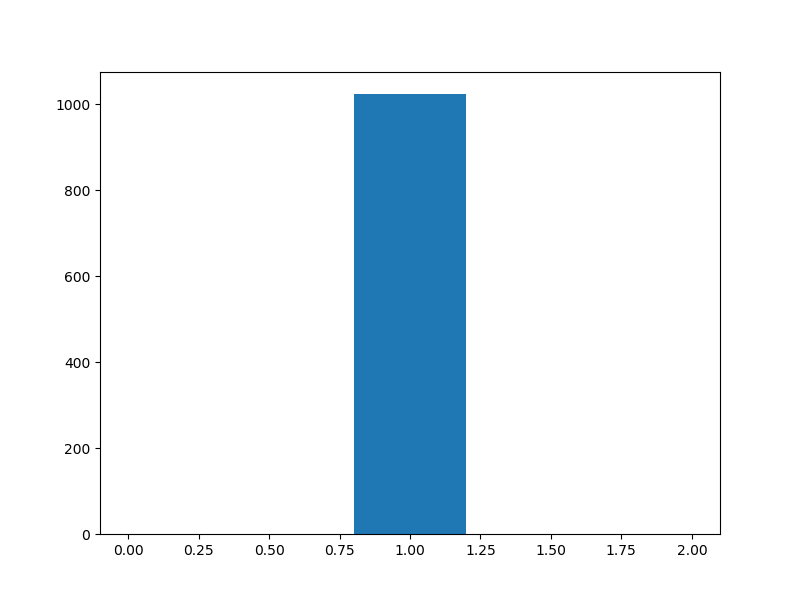

(array([    0.,     0.,  1024.,     0.,     0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [63]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [64]:
Z_test_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X_test).float())))
X_test_fit = model.decode(Z_test_fit).data.cpu().numpy()
Z_test_fit = Z_test_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


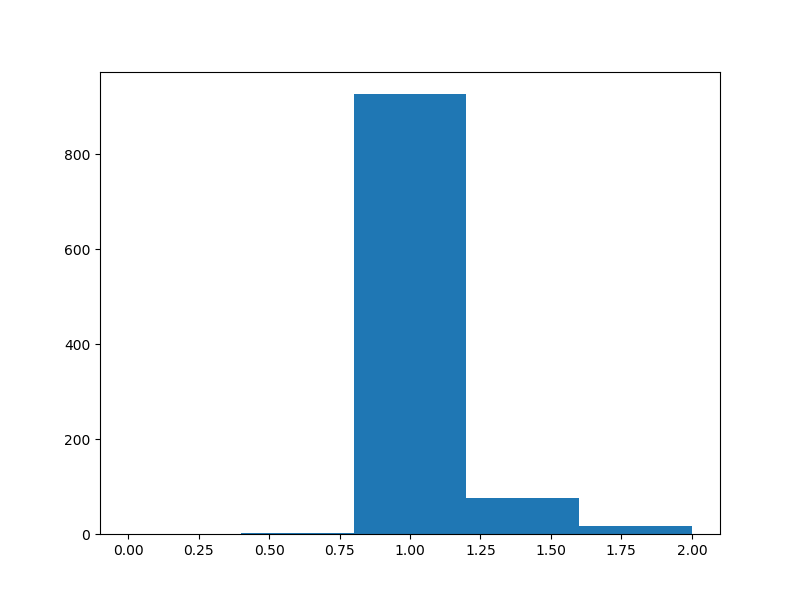

(array([   0.,    2.,  927.,   75.,   16.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [61]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_test_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

**VAE**

In [84]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    mu_q, sigma_q = q_distr
    mu_p, sigma_p = p_distr
    n, d = mu_p.shape
    return 0.5 * (
        torch.sum(
            (sigma_q ** 2 + (mu_p - mu_q) ** 2) / sigma_p ** 2 - 1 + 2 * (torch.log(sigma_p) - torch.log(sigma_q)), dim=1
        )
    )

In [85]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2):
        super(type(self), self).__init__()
        self.latent_dim = latent_dim
        
        self.proposal_network = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.proposal_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.proposal_network.append(nn.Softplus())
        self.proposal_mu_head = nn.Linear(hidden_dim, latent_dim)
        self.proposal_sigma_head = nn.Linear(hidden_dim, latent_dim)

        self.generative_network = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.generative_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.generative_network.append(nn.Softplus())
        self.generative_mu_head = nn.Linear(hidden_dim, input_dim)
        self.generative_sigma_head = nn.Linear(hidden_dim, input_dim)

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        for layer in self.proposal_network:
            x = layer(x)
        mu = self.proposal_mu_head(x)
        sigma = torch.exp(self.proposal_sigma_head(x))
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = cuda_wrapper(Variable(torch.zeros(n, self.latent_dim)))
        sigma = cuda_wrapper(Variable(torch.ones(n, self.latent_dim)))
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        mu, sigma = distr
        n, d = mu.shape
        eps = cuda_wrapper(Variable(torch.normal(means=torch.zeros(n, K, d))))
        return (mu.view(n, 1, d) + sigma.view(n, 1, d) * eps).view(n * K, d)

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        for layer in self.generative_network:
            z = layer(z)
        mu = self.generative_mu_head(z)
        sigma = torch.exp(self.generative_sigma_head(z))
        return mu, sigma

    def batch_loss(self, batch, K=1):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        n = batch.shape[0]
        q = self.proposal_distr(batch)
        zs = self.sample_latent(q, K)
        mu, sigma = self.generative_distr(zs)
        reconstruction_loss = torch.sum(((mu - batch) / sigma) ** 2 / 2 + torch.log(sigma), dim=1)
        regularization_loss = kl(q, self.prior_distr(n))
        return torch.mean(reconstruction_loss + regularization_loss)

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        return self.sample_latent(self.generative_distr(self.sample_prior(num_samples)))

In [89]:
epoch_count = 100000

model = cuda_wrapper(VAE(n_features, hidden_dim=n_features*2, latent_dim=n_latent+10))
optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit = model.sample_latent(model.generative_distr(Z_batch))
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count

    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit = model.sample_latent(model.generative_distr(Z_batch))
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, mean_scalar_product, mean_test_scalar_product
            )
        )


epoch 1000; loss = -319.8176 : -323.5226, scalar product = 3.1140 : 3.1980
epoch 2000; loss = -482.8022 : -477.7596, scalar product = 3.0819 : 3.0978
epoch 3000; loss = -425.2507 : -420.5558, scalar product = 2.5302 : 2.5751
epoch 4000; loss = -509.4038 : -499.6454, scalar product = 2.5850 : 2.6099
epoch 5000; loss = -420.2978 : -436.7156, scalar product = 2.3295 : 2.2122
epoch 6000; loss = -533.3023 : -510.8027, scalar product = 2.2510 : 2.2596
epoch 7000; loss = -481.9101 : -474.7780, scalar product = 1.8570 : 1.8714
epoch 8000; loss = -555.6912 : -516.5650, scalar product = 1.9699 : 1.9846
epoch 9000; loss = -523.9518 : -497.1745, scalar product = 1.7592 : 1.7581
epoch 10000; loss = -521.1446 : -498.1956, scalar product = 1.5897 : 1.6077
epoch 11000; loss = -567.4979 : -501.4327, scalar product = 1.6588 : 1.6812
epoch 12000; loss = -569.5216 : -494.8667, scalar product = 1.5396 : 1.5653
epoch 13000; loss = -519.4839 : -483.4516, scalar product = 1.3381 : 1.3827
epoch 14000; loss = -

KeyboardInterrupt: 

In [91]:
Z_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X).float()))))
X_fit = model.sample_latent(model.generative_distr(Z_fit)).data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


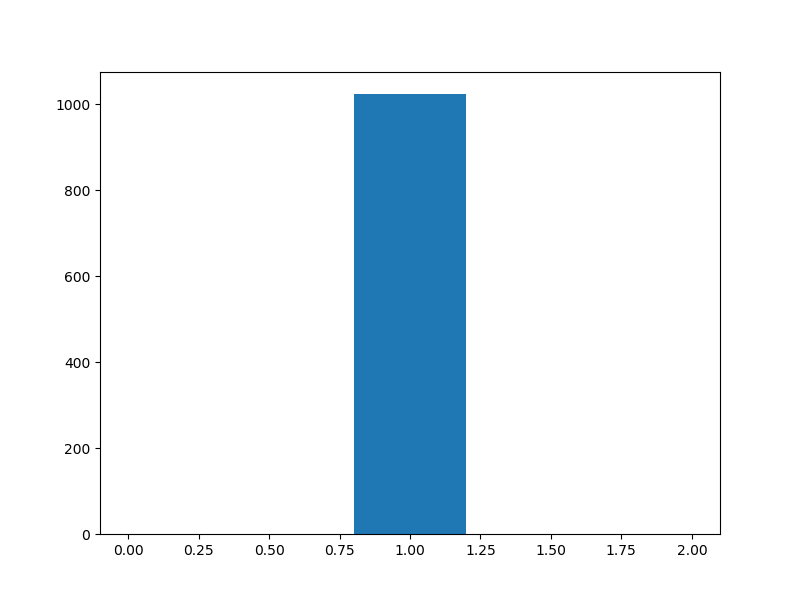

(array([    0.,     0.,  1024.,     0.,     0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [92]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [93]:
Z_test_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X_test).float()))))
X_test_fit = model.sample_latent(model.generative_distr(Z_test_fit)).data.cpu().numpy()
Z_test_fit = Z_test_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


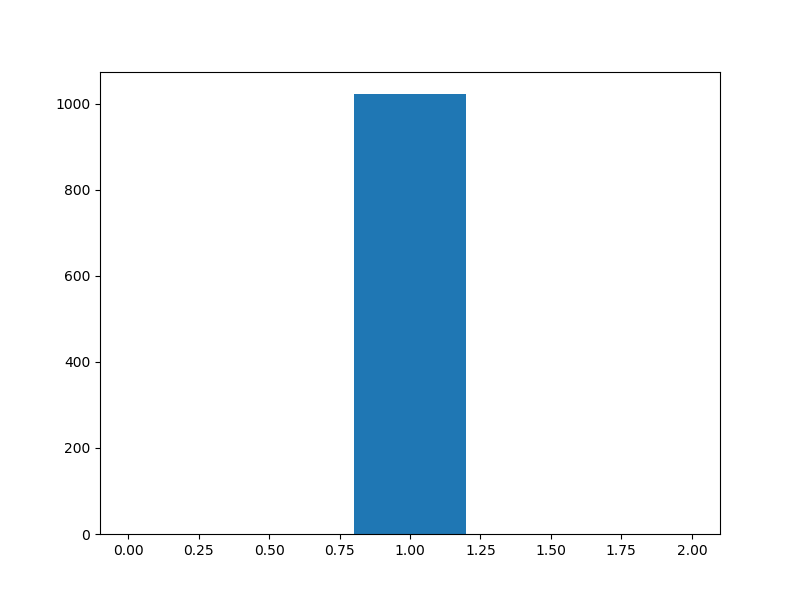

(array([  0.00000000e+00,   0.00000000e+00,   1.02300000e+03,
          1.00000000e+00,   0.00000000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [94]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_test_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [95]:
Z_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X).float()))))
X_fit = model.generative_distr(Z_fit)[0].data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


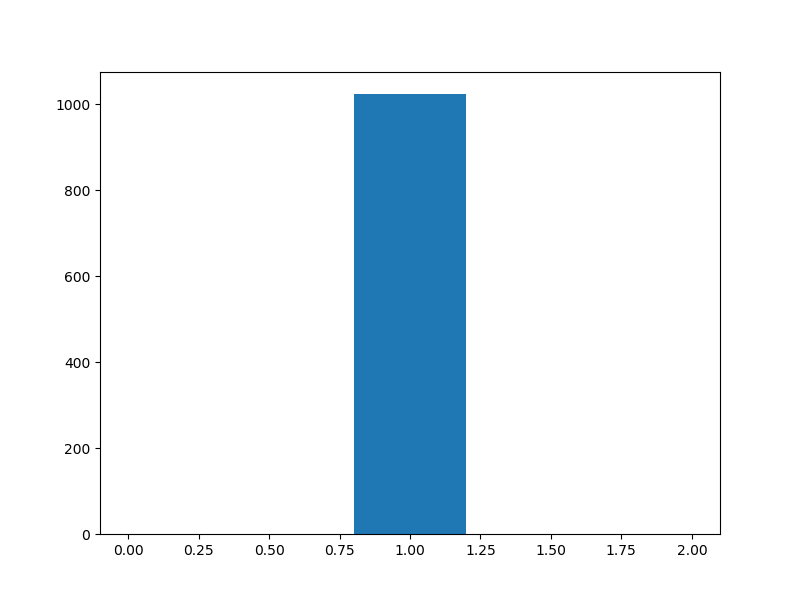

(array([    0.,     0.,  1024.,     0.,     0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [96]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [97]:
Z_test_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X_test).float()))))
X_test_fit = model.generative_distr(Z_test_fit)[0].data.cpu().numpy()
Z_test_fit = Z_test_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


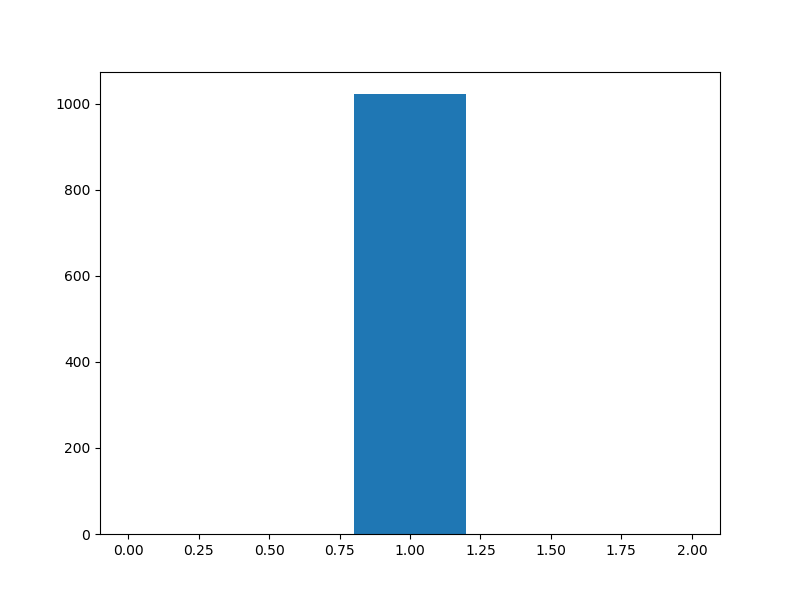

(array([  0.00000000e+00,   0.00000000e+00,   1.02300000e+03,
          1.00000000e+00,   0.00000000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [98]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_test_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

**VAE inside CAE**

In [360]:
epoch_count = 20000

latent_dim = 2
cae = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=latent_dim))
loss_function = nn.MSELoss()
optimizer = optim.Adam(cae.parameters())

contraction_factor = 1e-4

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = cae.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = cae.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}, contraction loss = {:.4f}, scalar product = {:.4f}'.format(
                epoch + 1, mean_loss, mean_contraction_loss, mean_scalar_product
            )
        )


epoch 500; loss = 0.0944, contraction loss = 0.0009, scalar product = 4.0969
epoch 1000; loss = 0.0070, contraction loss = 0.0021, scalar product = 4.9466
epoch 1500; loss = 0.0026, contraction loss = 0.0012, scalar product = 6.9913
epoch 2000; loss = 0.0015, contraction loss = 0.0009, scalar product = 2.9710
epoch 2500; loss = 0.0008, contraction loss = 0.0007, scalar product = 2.0176
epoch 3000; loss = 0.0006, contraction loss = 0.0005, scalar product = 1.5042
epoch 3500; loss = 0.0005, contraction loss = 0.0004, scalar product = 1.2208
epoch 4000; loss = 0.0003, contraction loss = 0.0003, scalar product = 0.8918
epoch 4500; loss = 0.0003, contraction loss = 0.0003, scalar product = 1.2351
epoch 5000; loss = 0.0002, contraction loss = 0.0002, scalar product = 0.7911
epoch 5500; loss = 0.0002, contraction loss = 0.0002, scalar product = 0.8632
epoch 6000; loss = 0.0002, contraction loss = 0.0002, scalar product = 0.5357
epoch 6500; loss = 0.0001, contraction loss = 0.0002, scalar prod

In [361]:
Z_fit = cae.encode(cuda_wrapper(Variable(torch.from_numpy(X).float()))).data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


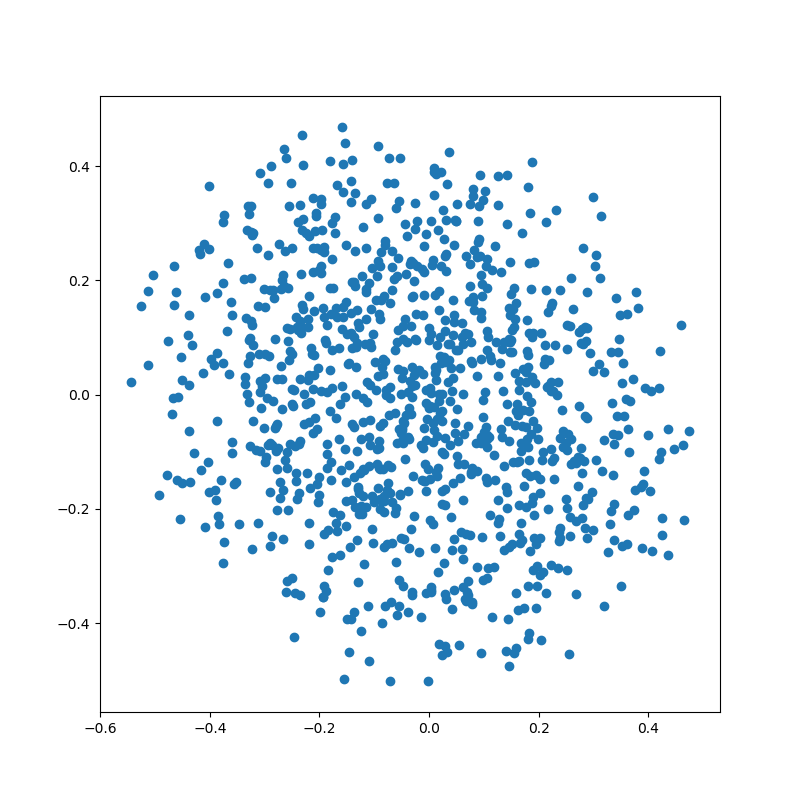

In [364]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

ax.scatter(Z_fit[:, 0], Z_fit[:, 1])

In [365]:
epoch_count = 20000

vae_inside = cuda_wrapper(VAE(latent_dim, hidden_dim=50, latent_dim=2))
optimizer = optim.Adam(vae_inside.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        Z_batch = cae.encode(X_batch)

        loss = vae_inside.batch_loss(Z_batch)
        cum_loss += loss.data[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}'.format(
                epoch + 1, mean_loss
            )
        )


epoch 500; loss = -2.1535
epoch 1000; loss = -2.1398
epoch 1500; loss = -2.1480
epoch 2000; loss = -2.2119
epoch 2500; loss = -2.1673
epoch 3000; loss = -2.1885
epoch 3500; loss = -2.1487
epoch 4000; loss = -2.1957
epoch 4500; loss = -2.1975
epoch 5000; loss = -2.1752
epoch 5500; loss = -2.1540
epoch 6000; loss = -2.2068
epoch 6500; loss = -2.2314
epoch 7000; loss = -2.1517
epoch 7500; loss = -2.1729
epoch 8000; loss = -2.1879
epoch 8500; loss = -2.2078
epoch 9000; loss = -2.1610
epoch 9500; loss = -2.1907
epoch 10000; loss = -2.1917
epoch 10500; loss = -2.1775
epoch 11000; loss = -2.2154
epoch 11500; loss = -2.1812
epoch 12000; loss = -2.2472
epoch 12500; loss = -2.1484
epoch 13000; loss = -2.2069
epoch 13500; loss = -2.1730
epoch 14000; loss = -2.1611
epoch 14500; loss = -2.1983
epoch 15000; loss = -2.2255
epoch 15500; loss = -2.2182
epoch 16000; loss = -2.1668
epoch 16500; loss = -2.1888
epoch 17000; loss = -2.2056
epoch 17500; loss = -2.1977
epoch 18000; loss = -2.1508
epoch 18500;

In [366]:
Z_gen = vae_inside.generate_samples(n_samples)
X_gen = cae.decode(Z_gen)

In [367]:
X_gen_requires_grad = Variable(X_gen.data, requires_grad=True)
X_gen_fit = cae(X_gen_requires_grad)

scalar_product = torch.sum(
    autograd.grad(
        [torch.sum(X_gen_fit ** 2)], [X_gen_requires_grad], retain_graph=True
    )[0].data ** 2, dim=1
)
print(torch.mean(scalar_product))

321.2150573730469


/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


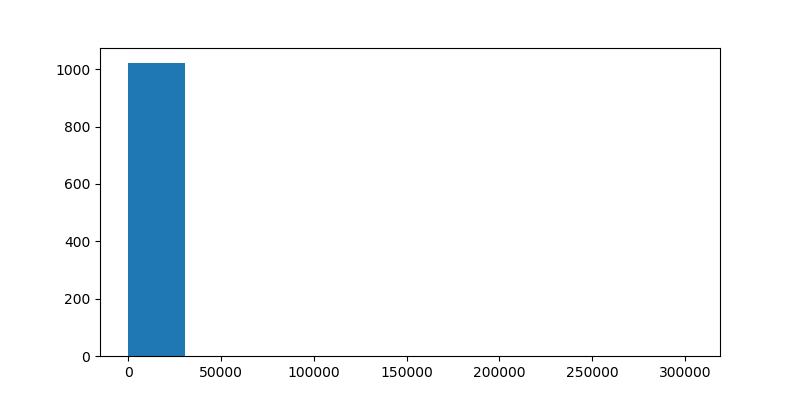

(array([  1.02300000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  5.92907043e-07,   3.03770813e+04,   6.07541625e+04,
          9.11312438e+04,   1.21508325e+05,   1.51885406e+05,
          1.82262488e+05,   2.12639569e+05,   2.43016650e+05,
          2.73393731e+05,   3.03770812e+05]),
 <a list of 10 Patch objects>)

In [368]:
fig = plt.figure(figsize=(8,4))
plt.hist(scalar_product.cpu().numpy())

In [369]:
Z_fit = cae.encode(cuda_wrapper(Variable(torch.from_numpy(X).float()))).data.cpu().numpy()
Z_gen = Z_gen.data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


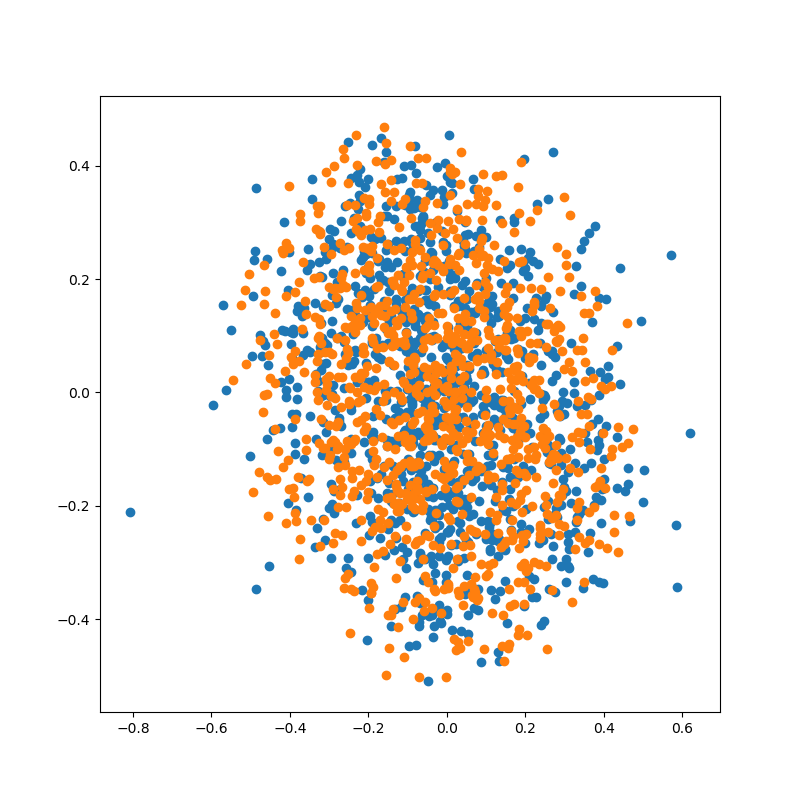

In [373]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

ax.scatter(Z_gen[:, 0], Z_gen[:, 1])
ax.scatter(Z_fit[:, 0], Z_fit[:, 1])

In [374]:
X_gen = X_gen.data.cpu().numpy()
X_gen_fit = X_gen_fit.data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


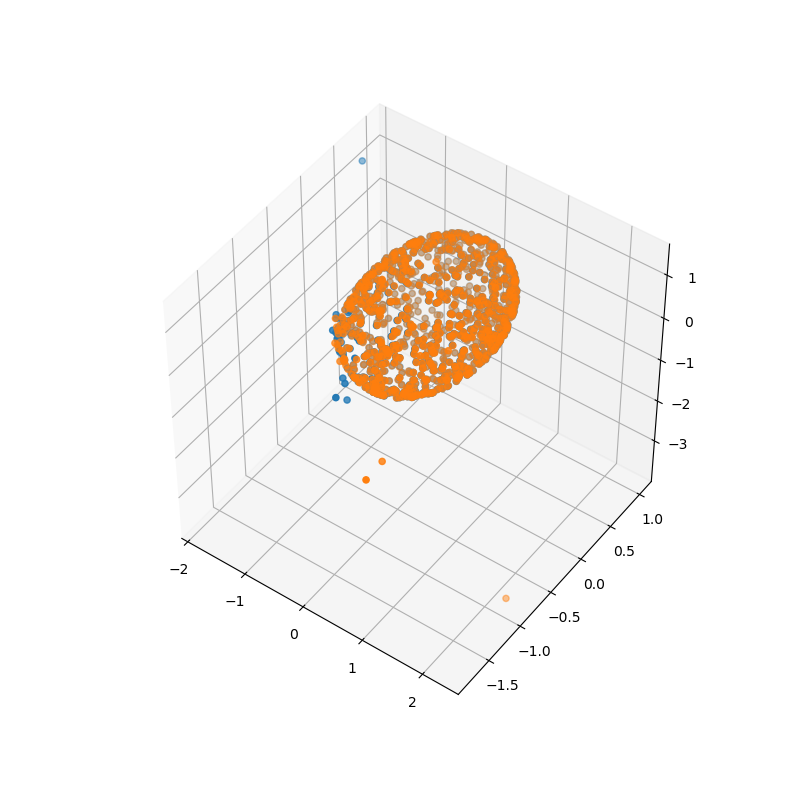

In [375]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X_gen[:, 0], X_gen[:, 1], X_gen[:, 2])
ax.scatter3D(X_gen_fit[:, 0], X_gen_fit[:, 1], X_gen_fit[:, 2])

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


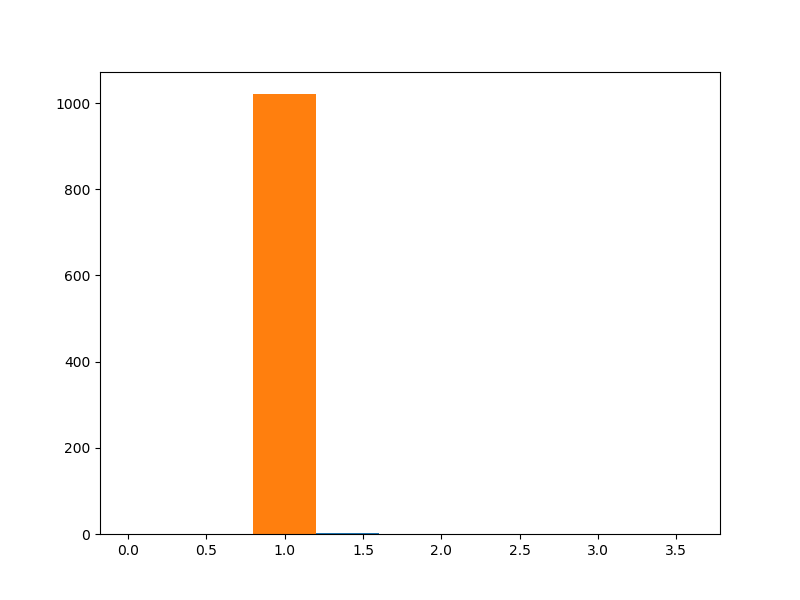

(array([  0.00000000e+00,   0.00000000e+00,   1.02100000e+03,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6]),
 <a list of 9 Patch objects>)

In [379]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_gen ** 2, axis=1)), bins=np.arange(0, 4, 0.4))
plt.hist(np.sqrt(np.sum(X_gen_fit ** 2, axis=1)), bins=np.arange(0, 4, 0.4))

In [311]:
epoch_count = 50000

latent_dim = 8
cae = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=latent_dim))
loss_function = nn.MSELoss()
optimizer = optim.Adam(cae.parameters())

contraction_factor = 1e-3

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = cae.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = cae.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}, contraction loss = {:.4f}, scalar product = {:.4f}'.format(
                epoch + 1, mean_loss, mean_contraction_loss, mean_scalar_product
            )
        )


epoch 500; loss = 0.0004, contraction loss = 0.0010, scalar product = 3.9127
epoch 1000; loss = 0.0000, contraction loss = 0.0007, scalar product = 3.9628
epoch 1500; loss = 0.0001, contraction loss = 0.0005, scalar product = 3.9425
epoch 2000; loss = 0.0006, contraction loss = 0.0005, scalar product = 3.9803
epoch 2500; loss = 0.0021, contraction loss = 0.0004, scalar product = 3.9661
epoch 3000; loss = 0.0000, contraction loss = 0.0004, scalar product = 3.9530
epoch 3500; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9521
epoch 4000; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9462
epoch 4500; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9448
epoch 5000; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9372
epoch 5500; loss = 0.0000, contraction loss = 0.0002, scalar product = 3.9365
epoch 6000; loss = 0.0000, contraction loss = 0.0002, scalar product = 3.9247
epoch 6500; loss = 0.0000, contraction loss = 0.0002, scalar prod

epoch 52500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.3289
epoch 53000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.3040
epoch 53500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.2763
epoch 54000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.2476
epoch 54500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.2244
epoch 55000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1951
epoch 55500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1703
epoch 56000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1473
epoch 56500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1222
epoch 57000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.0986
epoch 57500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.0723
epoch 58000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.0476
epoch 58500; loss = 0.0000, contraction loss = 0.000

**AE with sparse VD**

In [65]:
class FeatureSparsifier(nn.Module):
    def __init__(self, features, threshold):
        super(type(self), self).__init__()
        # in_features int
        # out_features int 
        # threshold float
        self.threshold = threshold

        # =======================================
        # Создайте параметры модели -- объекты класса Parameter
        # W размера (out_features x in_features)
        # log_sigma размера (out_features x in_features)
        # bias размера (1, out_features)
        # =======================================
        
        self.W = nn.Parameter(torch.zeros(features))
        self.log_sigma = nn.Parameter(torch.zeros(features))
        
        self.reset_parameters()

    def reset_parameters(self):
        # =======================================
        # Инициализируйте параметры модели
        # W -- нормальный случайный шум с центром в 0 и маленькой дисперсией
        # log_sigma -- маленьким значением ~ -5 
        # bias -- можно 0
        # =======================================    
        
        self.W.data = torch.normal(std=torch.zeros_like(self.W.data)+0.01)
        self.log_sigma.data = torch.zeros_like(self.log_sigma.data) - 5
        
    def forward(self, x):
        # =======================================
        # x: Variable containing: [torch.FloatTensor of size batch_size x in_features]
        # Return: type: Variable containing [torch.FloatTensor of size batch_size x out_features]
        # ----------------------------------------
        # Тут нужно написать forward шаг для Sparse VD слоя для минибатча объектов x
        # На этапе обучения: Вернуть семпл активаций с помощью Local Reparametrization Trick 
        # На этапе тестирования: Вернуть средние активации, посчитанные с обрезанными весами 
        # Правило обрезания весов: alpha_ij < self.threshold ====> w_ij = 0
        # ----------------------------------------
        # Клипинг alpha_ij, например torch.clamp(self.log_alpha, -10, 10) может улучшить стабильность 
        # Чтобы не встретить nan-ы используйте трюк log(a) = log(a + 1e-8)
        # ======================================= 
        
        if self.training:
            eps = Variable(torch.normal(means=torch.zeros_like(self.W.data)))
            theta = self.W + eps * torch.exp(self.log_sigma)
            return x * theta
        else:
            self.log_alpha = torch.clamp(2 * self.log_sigma.data - torch.log(self.W.data ** 2 + 1e-8), -10, 10)
            #alpha = torch.exp(self.log_alpha)
            W_clipped = Variable(self.W.data * (self.log_alpha < self.threshold).float())
            return x * W_clipped
        
    def kl_reg(self):
        # =======================================
        # Вернуть суммарную KL дивергенцию для всех параметров слоя 
        # Return: Variable containing: [torch.FloatTensor of size 1]
        # =======================================
        k1, k2, k3 = 0.63576, 1.87320, 1.48695
        self.log_alpha = torch.clamp(2 * self.log_sigma - torch.log(self.W ** 2 + 1e-8), -100, 100)
        return -torch.sum(k1 * F.sigmoid(k2 + k3 * self.log_alpha) - 0.5 * torch.log(1 + torch.exp(-self.log_alpha)))

In [66]:
class SparseLatentAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2, threshold=3):
        super(type(self), self).__init__()

        self.encoder = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.encoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.encoder.append(nn.Softplus())
        self.encoder.append(nn.Linear(hidden_dim, latent_dim))
        self.encoder.append(FeatureSparsifier(latent_dim, threshold))

        self.decoder = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.decoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.decoder.append(nn.Softplus())
        self.decoder.append(nn.Linear(hidden_dim, input_dim))

    def forward(self, X):
        Z = self.encode(X)
        return self.decode(Z)
    
    def encode(self, X):
        Z = X
        for layer in self.encoder:
            Z = layer(Z)
        return Z
    
    def decode(self, Z):
        X = Z
        for layer in self.decoder:
            X = layer(X)
        return X

In [83]:
epoch_count = 50000

model = cuda_wrapper(SparseLatentAE(n_features, hidden_dim=2*n_features, latent_dim=n_latent+10))
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    kl_weight = float(np.clip((epoch - 2000) / 40000, 0, 1))
    
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_penalty_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        X_batch_fit = model(X_batch_requires_grad)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        penalty_loss = 0
        for layer in model.modules():
            if isinstance(layer, FeatureSparsifier):
                penalty_loss += layer.kl_reg()
        penalty_loss = penalty_loss / X.shape[0]
        cum_penalty_loss += penalty_loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + kl_weight * penalty_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_penalty_loss = cum_penalty_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    
    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_penalty_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        X_batch_fit = model(X_batch_requires_grad)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        penalty_loss = 0
        for layer in model.modules():
            if isinstance(layer, FeatureSparsifier):
                penalty_loss += layer.kl_reg()
        penalty_loss = penalty_loss / X_test.shape[0]
        cum_penalty_loss += penalty_loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_penalty_loss = cum_penalty_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, penalty loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss,
                mean_penalty_loss, mean_test_penalty_loss,
                mean_scalar_product, mean_test_scalar_product
            )
        )
        for layer in model.modules():
            if isinstance(layer, FeatureSparsifier):
                #print(np.percentile(layer.log_alpha.data.cpu().numpy(), 90))
                print(np.sort(layer.log_alpha.data.cpu().numpy()))


epoch 1000; loss = 0.0000 : 0.0000, penalty loss = 0.0792 : 0.0792, scalar product = 3.3917 : 3.4127
[-9.56328964 -9.43316555 -9.08422565 -8.98866081 -8.95872688 -8.94062042
 -8.8302927  -8.76010132 -8.69568062 -8.50919247 -8.29917526 -8.01514149
 -7.8348217  -7.61473513 -7.34871244 -7.22997999 -7.03552246 -6.99107361
 -6.2011013  -5.89272451]
epoch 2000; loss = 0.0000 : 0.0000, penalty loss = 0.0935 : 0.0936, scalar product = 2.7883 : 2.7889
[-11.23457909 -11.16065502 -10.76513195 -10.7022934  -10.69188976
 -10.67005157 -10.65478706 -10.53957939 -10.52364063  -9.99254608
  -9.7057457   -9.37930584  -8.92717552  -8.84908485  -8.59178352
  -8.49171448  -8.31691837  -7.76040888  -7.59252882  -7.03894758]
epoch 3000; loss = 0.0001 : 0.0002, penalty loss = 0.0172 : 0.0172, scalar product = 1.5496 : 1.6921
[-4.3203516  -4.30282545 -4.29796696 -4.29326153 -4.24287987 -4.24148607
 -4.22825336 -4.21440649 -4.15801239 -4.14482689 -4.1345973   6.07873249
  7.43793678  7.45518684  7.47549152  7.4

epoch 25000; loss = 0.0036 : 0.0034, penalty loss = -0.0091 : -0.0091, scalar product = 3.8875 : 4.9176
[-0.65601492 -0.31845236 -0.28380489 -0.27927113 -0.20268106 -0.15516758
  3.29695988  4.11098003  6.10657644  6.243083    8.15272045  8.77355576
  8.78043652  8.9207449   9.08204746  9.1863308   9.19277096  9.22656727
  9.23276043  9.32064629]
epoch 26000; loss = 0.0036 : 0.0058, penalty loss = -0.0110 : -0.0110, scalar product = 5.9023 : 7.3502
[-0.54640627 -0.23944283  1.82974815  1.99883175  3.02249908  3.16237736
  3.76624632  4.08155441  5.54203796  5.55320835  6.77808619  8.62460136
  8.7115345   8.80031395  8.8065033   9.13930225  9.15330219  9.24778366
  9.28732777  9.37908268]
epoch 27000; loss = 0.0034 : 0.0038, penalty loss = -0.0112 : -0.0112, scalar product = 3.5714 : 6.0699
[-0.61037397 -0.09814548  2.42218256  2.68740845  3.17949629  4.26196337
  4.58596182  5.39823484  5.737607    5.75534868  7.06319332  8.1968689
  8.34003067  8.37719631  8.72683907  9.14514065  9.2

epoch 49000; loss = 0.0028 : 0.0046, penalty loss = -0.0124 : -0.0124, scalar product = 2.0943 : 10.7840
[  3.57988882   5.72094679   6.12313938   6.5898366    6.68770981
   7.1614542    7.17929459   7.52922869   7.58704281   8.08338642
   9.6204977    9.69330311   9.87079144   9.95349503  10.0197506
  10.04839802  10.04944324  10.08421612  10.23436832  12.67220402]
epoch 50000; loss = 0.0020 : 0.0039, penalty loss = -0.0124 : -0.0124, scalar product = 3.1183 : 7.2119
[  3.92158842   4.37763166   4.75334072   4.97452545   5.1334796
   5.16010761   5.57568073   7.37650633   8.55910206   8.84762096
   9.35907269   9.47240353   9.87956047   9.97615528  10.0256443
  10.03305626  10.07648087  10.12136364  10.13046932  13.79900074]


In [ ]:
# latent_dim = n_latent+10, kl_weight=0.1: (0.8-0.9 : 0.8-0.95)

In [77]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


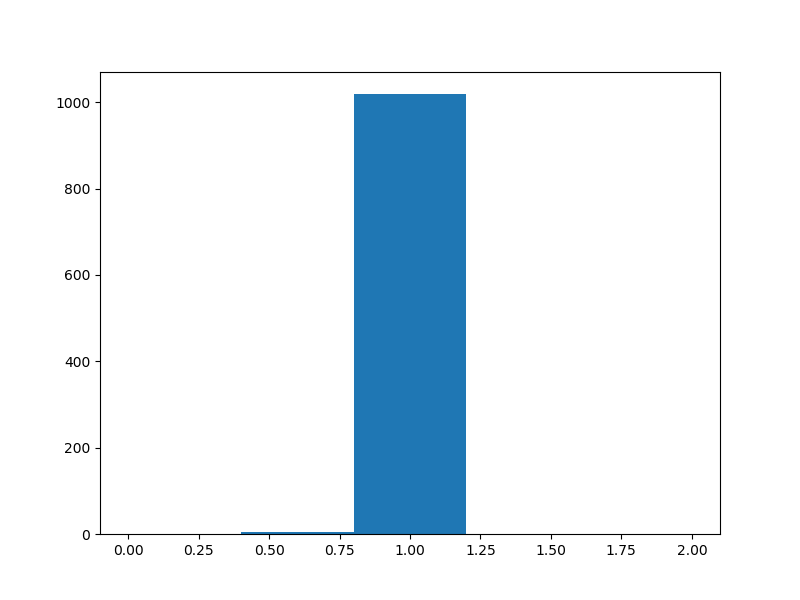

(array([    0.,     5.,  1019.,     0.,     0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [78]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [79]:
Z_test_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X_test).float())))
X_test_fit = model.decode(Z_test_fit).data.cpu().numpy()
Z_test_fit = Z_test_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


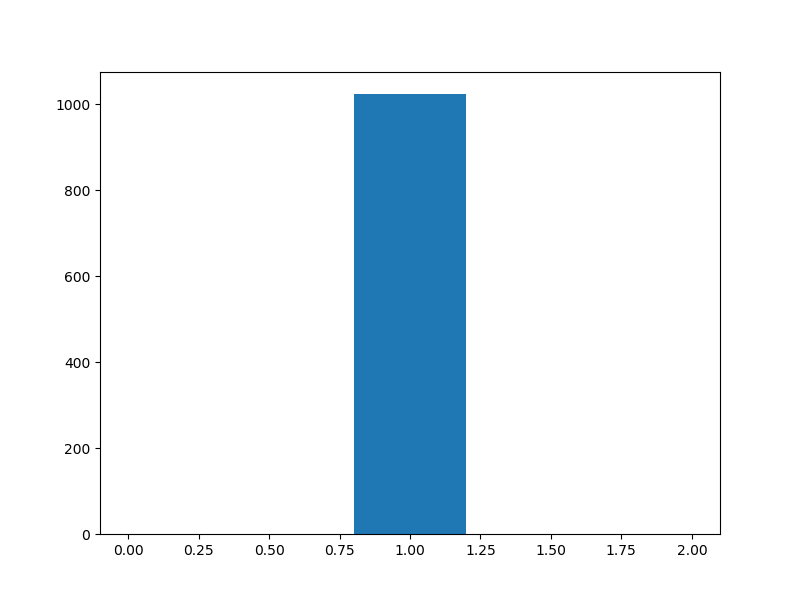

(array([    0.,     0.,  1024.,     0.,     0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [80]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_test_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

**WGAN-GP**

In [99]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, hidden_count=2):
        super(type(self), self).__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            #nn.Dropout(p=0.5),
            nn.LeakyReLU(negative_slope=0.2)
        ])
        for _ in range(hidden_count-1):
            self.decoder.append(nn.Linear(hidden_dim, hidden_dim))
            #self.decoder.append(nn.Dropout(p=0.5)),
            self.decoder.append(nn.LeakyReLU(negative_slope=0.2))
        self.decoder.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, Z):
        X = Z
        for layer in self.decoder:
            X = layer(X)
        return X

In [100]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_count=2):
        super(type(self), self).__init__()

        self.layers = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            #nn.Dropout(p=0.5),
            nn.LeakyReLU(negative_slope=0.2)
        ])
        for _ in range(hidden_count-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            #self.layers.append(nn.Dropout(p=0.5)),
            self.layers.append(nn.LeakyReLU(negative_slope=0.2))
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [101]:
epoch_count = 200000

generator = cuda_wrapper(Generator(output_dim=n_features, hidden_dim=n_features*2, latent_dim=n_latent+10, hidden_count=2))
discriminator = cuda_wrapper(Discriminator(input_dim=n_features, hidden_dim=n_features*2, hidden_count=2))
generator_opt = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.9))
discriminator_opt = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.9))

reg_lambda = 2

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_generator_loss = 0
    cum_discriminator_loss = 0
    cum_value_batch_hat_grad_sqr_norm = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch_true = cuda_wrapper(Variable(X_batch))
        
        Z_batch_gen = cuda_wrapper(Variable(torch.normal(means=torch.zeros(X_batch.shape[0], generator.latent_dim))))
        X_batch_gen = generator(Z_batch_gen)

        value_batch_true = discriminator(X_batch_true)
        value_batch_gen = discriminator(X_batch_gen)
        
        discriminator_loss = -0.5 * torch.mean(
            value_batch_true - value_batch_gen
        )
        generator_loss = -torch.mean(value_batch_gen)
        cum_generator_loss += generator_loss.data[0]
        cum_discriminator_loss += discriminator_loss.data[0]
        
        do_generator_update = (epoch * X.shape[0] // X_batch.shape[0] + batch_count) % 100 == 0
        
        if do_generator_update:
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
        else:
            eps = np.random.uniform()
            X_batch_hat = Variable(X_batch_true.data * eps + X_batch_gen.data * (1 - eps), requires_grad=True)
            value_batch_hat = discriminator(X_batch_hat)
            value_batch_hat_grad_sqr_norm = torch.sum(
                autograd.grad([torch.sum(value_batch_hat)], [X_batch_hat], create_graph=True)[0] ** 2, dim=-1
            )
            cum_value_batch_hat_grad_sqr_norm += torch.mean(value_batch_hat_grad_sqr_norm).data[0]
            reg_loss = (torch.sqrt(value_batch_hat_grad_sqr_norm) - 1) ** 2

            discriminator_opt.zero_grad()
            (discriminator_loss + reg_lambda * torch.mean(reg_loss)).backward()
            discriminator_opt.step()
        batch_count += 1
    mean_generator_loss = cum_generator_loss / batch_count
    mean_discriminator_loss = cum_discriminator_loss / batch_count
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; generator loss = {:.4f}, discriminator loss = {:.4f}'.format(
                epoch + 1, mean_generator_loss / np.log(4), mean_discriminator_loss / np.log(4)
            )
        )
        print(
            'generated smaples norm: mean = {:.2f}, std = {:.2f}'.format(
                torch.mean(torch.sqrt(torch.sum(X_batch_gen.data ** 2, dim=1))), 
                torch.std(torch.sqrt(torch.sum(X_batch_gen.data ** 2, dim=1)))
            )
        )
        print(cum_value_batch_hat_grad_sqr_norm / batch_count)


epoch 1000; generator loss = 0.3747, discriminator loss = -0.3542
generated smaples norm: mean = 0.74, std = 0.13
1.2174031734466553
epoch 2000; generator loss = 0.2127, discriminator loss = -0.2405
generated smaples norm: mean = 0.72, std = 0.15
1.1715204417705536
epoch 3000; generator loss = 0.2157, discriminator loss = -0.1389
generated smaples norm: mean = 0.95, std = 0.20
1.0964552462100983
epoch 4000; generator loss = 0.5928, discriminator loss = -0.1024
generated smaples norm: mean = 1.04, std = 0.23
1.0711599290370941
epoch 5000; generator loss = 0.9315, discriminator loss = -0.0978
generated smaples norm: mean = 1.02, std = 0.21
1.0649354755878448
epoch 6000; generator loss = 1.2555, discriminator loss = -0.0933
generated smaples norm: mean = 1.00, std = 0.21
1.066637933254242
epoch 7000; generator loss = 1.5065, discriminator loss = -0.0870
generated smaples norm: mean = 0.99, std = 0.20
1.0474915206432343
epoch 8000; generator loss = 1.6169, discriminator loss = -0.0853
gene

epoch 63000; generator loss = 1.4679, discriminator loss = -0.0807
generated smaples norm: mean = 0.95, std = 0.07
1.07868292927742
epoch 64000; generator loss = 1.4365, discriminator loss = -0.0805
generated smaples norm: mean = 0.97, std = 0.08
1.104816883802414
epoch 65000; generator loss = 1.4630, discriminator loss = -0.0798
generated smaples norm: mean = 0.96, std = 0.08
1.0278644412755966
epoch 66000; generator loss = 1.4797, discriminator loss = -0.0808
generated smaples norm: mean = 0.97, std = 0.08
1.008266106247902
epoch 67000; generator loss = 1.3880, discriminator loss = -0.0788
generated smaples norm: mean = 0.95, std = 0.07
1.04507315158844
epoch 68000; generator loss = 1.3846, discriminator loss = -0.0809
generated smaples norm: mean = 0.95, std = 0.07
1.0284446328878403
epoch 69000; generator loss = 1.3879, discriminator loss = -0.0791
generated smaples norm: mean = 0.96, std = 0.06
0.9726677089929581
epoch 70000; generator loss = 1.3331, discriminator loss = -0.0810
g

epoch 125000; generator loss = 0.4249, discriminator loss = -0.0841
generated smaples norm: mean = 0.96, std = 0.06
1.0939580798149109
epoch 126000; generator loss = 0.4136, discriminator loss = -0.0841
generated smaples norm: mean = 0.96, std = 0.07
1.0215592086315155
epoch 127000; generator loss = 0.4166, discriminator loss = -0.0852
generated smaples norm: mean = 0.96, std = 0.06
1.063120424747467
epoch 128000; generator loss = 0.4071, discriminator loss = -0.0833
generated smaples norm: mean = 0.96, std = 0.06
1.0279610902071
epoch 129000; generator loss = 0.3553, discriminator loss = -0.0855
generated smaples norm: mean = 0.96, std = 0.07
1.0883769690990448
epoch 130000; generator loss = 0.4054, discriminator loss = -0.0833
generated smaples norm: mean = 0.96, std = 0.07
0.9668694287538528
epoch 131000; generator loss = 0.4005, discriminator loss = -0.0854
generated smaples norm: mean = 0.95, std = 0.06
1.0698604583740234
epoch 132000; generator loss = 0.3940, discriminator loss =

epoch 186000; generator loss = 0.2538, discriminator loss = -0.0842
generated smaples norm: mean = 0.96, std = 0.06
1.068846508860588
epoch 187000; generator loss = 0.2793, discriminator loss = -0.0839
generated smaples norm: mean = 0.97, std = 0.06
0.9585356116294861
epoch 188000; generator loss = 0.2613, discriminator loss = -0.0843
generated smaples norm: mean = 0.96, std = 0.06
1.0782434940338135
epoch 189000; generator loss = 0.2382, discriminator loss = -0.0846
generated smaples norm: mean = 0.96, std = 0.06
1.0113231092691422
epoch 190000; generator loss = 0.2215, discriminator loss = -0.0849
generated smaples norm: mean = 0.95, std = 0.06
1.05790314078331
epoch 191000; generator loss = 0.2332, discriminator loss = -0.0847
generated smaples norm: mean = 0.96, std = 0.06
1.0679820775985718
epoch 192000; generator loss = 0.2452, discriminator loss = -0.0836
generated smaples norm: mean = 0.96, std = 0.06
1.0445254445075989
epoch 193000; generator loss = 0.2425, discriminator loss 

In [105]:
X_batch_gen = X_batch_gen.data.cpu().numpy()

AttributeError: 'memoryview' object has no attribute 'cpu'

<IPython.core.display.Javascript object>


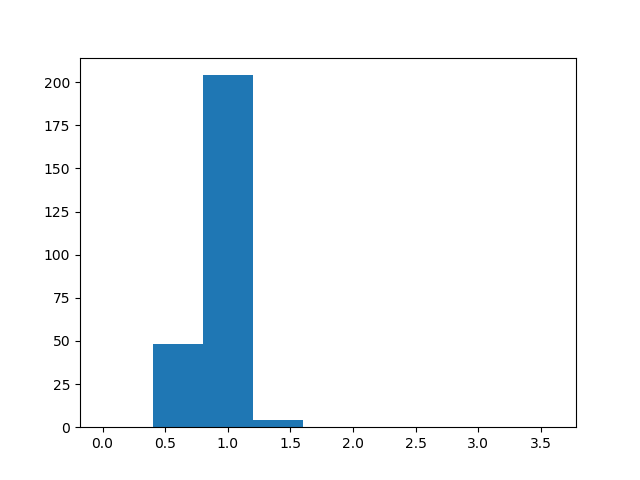

(array([   0.,   48.,  204.,    4.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6]),
 <a list of 9 Patch objects>)

In [106]:
fig = plt.figure()
plt.hist(np.sum(X_batch_gen ** 2, axis=1), bins=np.arange(0, 4, 0.4))


In [109]:
epoch_count = 50000

latent_dim = n_latent + 10
#cae = cuda_wrapper(AE(n_features, hidden_dim=n_features*2, latent_dim=latent_dim))
#loss_function = nn.MSELoss()
#optimizer = optim.Adam(cae.parameters())

contraction_factor = 1e-6

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = cae.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = cae.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    
    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = cae.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = cae.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_contraction_loss = cum_contraction_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, contraction loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, 
                mean_contraction_loss, mean_test_contraction_loss, 
                mean_scalar_product, mean_test_scalar_product
            )
        )


epoch 1000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.9994 : 2.1053
epoch 2000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.9565 : 2.0381
epoch 3000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.9272 : 1.9929
epoch 4000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.8947 : 1.9381
epoch 5000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.8417 : 1.9109
epoch 6000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.8332 : 1.9202
epoch 7000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.8049 : 1.8813
epoch 8000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.7650 : 1.8399
epoch 9000; loss = 0.0000 : 0.0000, contraction loss = 0.0000 : 0.0000, scalar product = 1.7464 : 1.8163
epoch 10000; loss = 0.0000 : 0.0000, contraction loss =

KeyboardInterrupt: 

In [110]:
epoch_count = 200000

generator = cuda_wrapper(Generator(output_dim=latent_dim, hidden_dim=latent_dim*2, latent_dim=latent_dim, hidden_count=2))
discriminator = cuda_wrapper(Discriminator(input_dim=latent_dim, hidden_dim=latent_dim*2, hidden_count=2))
generator_opt = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.9))
discriminator_opt = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.9))

reg_lambda = 2

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_discriminator_loss = 0
    cum_scalar_product = 0
    cum_value_batch_hat_grad_sqr_norm = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch_true = cuda_wrapper(Variable(X_batch))
        Z_batch_true = cae.encode(X_batch_true)
        
        Z_batch_gen = generator(
            cuda_wrapper(Variable(torch.normal(means=torch.zeros(X_batch.shape[0], generator.latent_dim))))
        )
        X_batch_gen_requires_grad = Variable(cae.decode(Z_batch_gen).data, requires_grad=True)
        X_batch_gen_fit = cae(X_batch_gen_requires_grad)

        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_gen_fit ** 2)], [X_batch_gen_requires_grad]
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        value_batch_true = discriminator(Z_batch_true)
        value_batch_gen = discriminator(Z_batch_gen)
        
        discriminator_loss = -0.5 * torch.mean(
            value_batch_true - value_batch_gen
        )
        cum_discriminator_loss += discriminator_loss.data[0]
        
        do_generator_update = (epoch * X.shape[0] // X_batch.shape[0] + batch_count) % 100 == 0
        
        if do_generator_update:
            generator_opt.zero_grad()
            (-discriminator_loss).backward()
            generator_opt.step()
        else:
            eps = np.random.uniform()
            Z_batch_hat = Variable(Z_batch_true.data * eps + Z_batch_gen.data * (1 - eps), requires_grad=True)
            value_batch_hat = discriminator(Z_batch_hat)
            value_batch_hat_grad_sqr_norm = torch.sum(
                autograd.grad([torch.sum(value_batch_hat)], [Z_batch_hat], create_graph=True)[0] ** 2, dim=-1
            )
            cum_value_batch_hat_grad_sqr_norm += torch.mean(value_batch_hat_grad_sqr_norm).data[0]
            reg_loss = (torch.sqrt(value_batch_hat_grad_sqr_norm) - 1) ** 2

            discriminator_opt.zero_grad()
            (discriminator_loss + reg_lambda * torch.mean(reg_loss)).backward()
            discriminator_opt.step()
        batch_count += 1
    mean_discriminator_loss = cum_discriminator_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; discriminator loss = {:.4f}'.format(
                epoch + 1, mean_discriminator_loss
            )
        )
        print(
            'generated samples norm: mean = {:.2f}, std = {:.2f}'.format(
                torch.mean(torch.sqrt(torch.sum(X_batch_gen_requires_grad.data ** 2, dim=1))), 
                torch.std(torch.sqrt(torch.sum(X_batch_gen_requires_grad.data ** 2, dim=1)))
            )
        )
        print('scalar product = {:.4f}'.format(mean_scalar_product))
        print(cum_value_batch_hat_grad_sqr_norm / batch_count)
        print()

epoch 1000; discriminator loss = -0.4753
generated samples norm: mean = 3.46, std = 2.13
scalar product = 44.1598
1.2230973839759827

epoch 2000; discriminator loss = -0.4054
generated samples norm: mean = 2.50, std = 1.46
scalar product = 55742.1114
1.1916820108890533

epoch 3000; discriminator loss = -0.3424
generated samples norm: mean = 1.82, std = 1.04
scalar product = 5.2546
1.1698009073734283

epoch 4000; discriminator loss = -0.2813
generated samples norm: mean = 1.72, std = 1.30
scalar product = 7.6861
1.1347164511680603

epoch 5000; discriminator loss = -0.2204
generated samples norm: mean = 1.87, std = 1.25
scalar product = 32.2755
1.1052045822143555

epoch 6000; discriminator loss = -0.1712
generated samples norm: mean = 1.83, std = 1.13
scalar product = 3447.2513
1.0851459205150604

epoch 7000; discriminator loss = -0.1311
generated samples norm: mean = 1.91, std = 1.12
scalar product = 7.9111
1.0354159772396088

epoch 8000; discriminator loss = -0.1054
generated samples n

epoch 63000; discriminator loss = -0.0099
generated samples norm: mean = 1.00, std = 0.33
scalar product = 1.6378
1.0065885782241821

epoch 64000; discriminator loss = -0.0097
generated samples norm: mean = 1.01, std = 0.33
scalar product = 1.6156
1.0029727518558502

epoch 65000; discriminator loss = -0.0096
generated samples norm: mean = 0.98, std = 0.31
scalar product = 1.6352
1.0032572895288467

epoch 66000; discriminator loss = -0.0099
generated samples norm: mean = 0.98, std = 0.28
scalar product = 1.6222
1.005169928073883

epoch 67000; discriminator loss = -0.0098
generated samples norm: mean = 1.01, std = 0.28
scalar product = 1.5438
1.0048653483390808

epoch 68000; discriminator loss = -0.0114
generated samples norm: mean = 1.02, std = 0.32
scalar product = 1.6077
1.0075014233589172

epoch 69000; discriminator loss = -0.0103
generated samples norm: mean = 0.99, std = 0.32
scalar product = 1.6029
1.0004028379917145

epoch 70000; discriminator loss = -0.0099
generated samples nor

epoch 125000; discriminator loss = -0.0108
generated samples norm: mean = 0.99, std = 0.25
scalar product = 1.6311
1.002390593290329

epoch 126000; discriminator loss = -0.0103
generated samples norm: mean = 1.02, std = 0.25
scalar product = 1.5998
1.0002851039171219

epoch 127000; discriminator loss = -0.0088
generated samples norm: mean = 1.02, std = 0.25
scalar product = 1.6650
1.001167967915535

epoch 128000; discriminator loss = -0.0099
generated samples norm: mean = 1.03, std = 0.25
scalar product = 1.6127
1.0026888847351074

epoch 129000; discriminator loss = -0.0097
generated samples norm: mean = 1.02, std = 0.24
scalar product = 1.6168
1.0033382028341293

epoch 130000; discriminator loss = -0.0097
generated samples norm: mean = 1.01, std = 0.25
scalar product = 1.6364
1.0019777715206146

epoch 131000; discriminator loss = -0.0097
generated samples norm: mean = 1.02, std = 0.25
scalar product = 1.6332
1.0065326988697052

epoch 132000; discriminator loss = -0.0096
generated samp

epoch 186000; discriminator loss = -0.0079
generated samples norm: mean = 0.99, std = 0.19
scalar product = 1.6383
1.003087341785431

epoch 187000; discriminator loss = -0.0079
generated samples norm: mean = 1.02, std = 0.19
scalar product = 1.6334
1.0042873322963715

epoch 188000; discriminator loss = -0.0089
generated samples norm: mean = 1.04, std = 0.19
scalar product = 1.6155
1.0046207010746002

epoch 189000; discriminator loss = -0.0083
generated samples norm: mean = 1.00, std = 0.21
scalar product = 1.6276
1.0026619136333466

epoch 190000; discriminator loss = -0.0073
generated samples norm: mean = 1.00, std = 0.20
scalar product = 1.6578
0.9974524527788162

epoch 191000; discriminator loss = -0.0086
generated samples norm: mean = 1.01, std = 0.19
scalar product = 1.6360
1.0033617466688156

epoch 192000; discriminator loss = -0.0086
generated samples norm: mean = 1.02, std = 0.21
scalar product = 1.6520
1.008186161518097

epoch 193000; discriminator loss = -0.0082
generated samp

**WAE-MMD**

In [111]:
def kernel(X, Y, C=2*latent_dim):
    return C / (C + torch.sum((X.view(1, *X.shape) - Y.view(Y.shape[0], 1, Y.shape[1])) ** 2, dim=2))

In [112]:
def maximum_mean_discrepancy(X, Y):
    assert X.shape == Y.shape
    n = X.shape[0]
    X_kernel = kernel(X, X)
    X_term = (torch.sum(X_kernel) - torch.trace(X_kernel)) / (n * (n-1))
    Y_kernel = kernel(Y, Y)
    Y_term = (torch.sum(Y_kernel) - torch.trace(Y_kernel)) / (n * (n-1))
    XY_kernel = kernel(X, Y)
    XY_term = 2 * torch.sum(XY_kernel) / (n * n)
    return X_term + Y_term - XY_term
    

In [113]:
class WAE_MMD(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2, regularization_factor=10):
        super(type(self), self).__init__()
        self.latent_dim = latent_dim
        self.regularization_factor = regularization_factor
        
        self.proposal_network = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.proposal_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.proposal_network.append(nn.Softplus())
        self.proposal_mu_head = nn.Linear(hidden_dim, latent_dim)
        self.proposal_sigma_head = nn.Linear(hidden_dim, latent_dim)

        self.generative_network = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.generative_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.generative_network.append(nn.Softplus())
        self.generative_mu_head = nn.Linear(hidden_dim, input_dim)
        #self.generative_sigma_head = nn.Linear(hidden_dim, input_dim)

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        for layer in self.proposal_network:
            x = layer(x)
        mu = self.proposal_mu_head(x)
        sigma = torch.exp(self.proposal_sigma_head(x))
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = cuda_wrapper(Variable(torch.zeros(n, self.latent_dim)))
        sigma = cuda_wrapper(Variable(torch.ones(n, self.latent_dim)))
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        mu, sigma = distr
        n, d = mu.shape
        eps = cuda_wrapper(Variable(torch.normal(means=torch.zeros(n, K, d))))
        return (mu.view(n, 1, d) + sigma.view(n, 1, d) * eps).view(n * K, d)

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        for layer in self.generative_network:
            z = layer(z)
        mu = self.generative_mu_head(z)
        #sigma = torch.exp(self.generative_sigma_head(z))
        return mu

    def batch_loss(self, batch, K=1):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        n = batch.shape[0]
        q = self.proposal_distr(batch)
        zs = self.sample_latent(q, K)
        zs_prior = self.sample_prior(n)
        batch_rec = self.generative_distr(zs)
        reconstruction_loss = torch.sum((batch_rec - batch) ** 2) / n
        regularization_loss = maximum_mean_discrepancy(zs, zs_prior) * self.regularization_factor
        return reconstruction_loss + regularization_loss

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        return self.generative_distr(self.sample_prior(num_samples))

In [116]:
epoch_count = 100000

latent_dim = n_latent + 10
#model = cuda_wrapper(WAE_MMD(n_features, hidden_dim=n_features*2, latent_dim=latent_dim))
#optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit = model.generative_distr(Z_batch)
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count

    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit = model.generative_distr(Z_batch)
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, 
                mean_scalar_product, mean_test_scalar_product
            )
        )


epoch 1000; loss = -0.0074 : 0.0443, scalar product = 11.4968 : 23.1312
epoch 2000; loss = -0.0012 : 0.0385, scalar product = 10.9105 : 25.2116
epoch 3000; loss = -0.0017 : 0.0392, scalar product = 11.8312 : 22.5124
epoch 4000; loss = -0.0033 : 0.0368, scalar product = 11.2194 : 24.5382
epoch 5000; loss = 0.0015 : 0.0339, scalar product = 10.7040 : 23.1771
epoch 6000; loss = 0.0007 : 0.0391, scalar product = 10.4581 : 24.9947
epoch 7000; loss = 0.0049 : 0.0403, scalar product = 10.3829 : 25.2487
epoch 8000; loss = 0.0004 : 0.0389, scalar product = 11.2816 : 20.4262
epoch 9000; loss = 0.0024 : 0.0401, scalar product = 10.0498 : 22.6764
epoch 10000; loss = 0.0006 : 0.0370, scalar product = 10.6349 : 23.1589
epoch 11000; loss = -0.0040 : 0.0414, scalar product = 10.1047 : 22.4709
epoch 12000; loss = 0.0028 : 0.0432, scalar product = 10.3800 : 26.7213
epoch 13000; loss = -0.0037 : 0.0372, scalar product = 10.1930 : 27.0629
epoch 14000; loss = -0.0001 : 0.0424, scalar product = 10.0181 : 27